In [1]:
!pip install transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import json
import random
from sklearn.model_selection import train_test_split

dataset_path = "/content/combined_dataset.json"
with open(dataset_path, "r") as file:
    data = json.load(file)

# Extract sentences, sentiments, and trends
sentences = [item["sentence"] for item in data]
sentiments = [item["sentiment"] for item in data]
keywords = [item["keywords"] for item in data]
trends = [item["trends"] for item in data]

# Flatten sentences (assuming each "sentence" entry is a list)
flat_sentences = [" ".join(sentence_group) for sentence_group in sentences]

# Split into train and test
train_texts, test_texts, train_sentiments, test_sentiments, train_trends, test_trends = train_test_split(
    flat_sentences, sentiments, trends, test_size=0.2, random_state=42
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,3.202500,2.675294
2,1.592000,1.473008
3,0.940800,1.123913
4,0.831300,1.043875
5,0.758000,1.012358
6,0.688300,0.995598
7,0.740100,0.977120
8,0.692400,0.965712
9,0.631700,0.969085
10,0.652200,0.969572


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


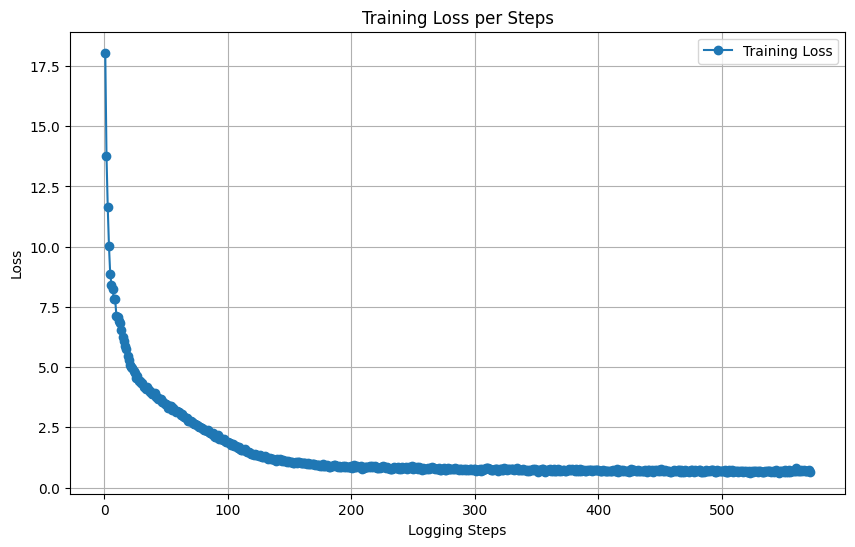

In [3]:
from transformers import BartForConditionalGeneration, BartTokenizer, TrainingArguments, Trainer, TrainerCallback
from datasets import Dataset
import torch
import matplotlib.pyplot as plt

# Load tokenizer and model
trends_tokenizer = BartTokenizer.from_pretrained("ml6team/keyphrase-generation-keybart-inspec")
trends_model = BartForConditionalGeneration.from_pretrained("ml6team/keyphrase-generation-keybart-inspec")

def preprocess_trends_data(texts, targets):
    inputs = [f"extract keyphrases: {text}" for text in texts]
    # Tokenize and convert to lists for Dataset.from_dict
    input_encodings = trends_tokenizer(inputs, max_length=512, truncation=True, padding=True)
    target_encodings = trends_tokenizer(targets, max_length=512, truncation=True, padding=True)
    return {
        "input_ids": input_encodings.input_ids,
        "attention_mask": input_encodings.attention_mask,
        "labels": target_encodings.input_ids,
    }

# Preprocess data
train_data = preprocess_trends_data(train_texts, ["; ".join(trend) for trend in train_trends])
test_data = preprocess_trends_data(test_texts, ["; ".join(trend) for trend in test_trends])

# Create datasets using Dataset.from_dict
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

# Fine-tuning
training_args = TrainingArguments(
    output_dir="./trends_results",
    evaluation_strategy="epoch",
    learning_rate=3e-6,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
)

# Custom callback to track training loss
class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.losses.append(logs["loss"])

# Initialize loss tracker
loss_tracker = LossTrackerCallback()

trainer = Trainer(
    model=trends_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=trends_tokenizer,
    callbacks=[loss_tracker],
)

# Fine-tune
trainer.train()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_tracker.losses) + 1), loss_tracker.losses, marker='o', label="Training Loss")
plt.title("Training Loss per Steps")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:

%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

# Generate predictions
test_input_ids = test_dataset["input_ids"]  # Get input_ids from test_dataset
batch_size = 4  
predicted_trends = []
for i in range(0, len(test_input_ids), batch_size):
    # Convert the list of lists to a PyTorch tensor
    batch_input_ids = torch.tensor(test_input_ids[i : i + batch_size])
    # Now you can move it to the device
    batch_input_ids = batch_input_ids.to(trends_model.device)
    outputs = trends_model.generate(
        batch_input_ids, max_length=50, num_beams=5, early_stopping=True
    )
    predicted_trends.extend(
        [trends_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    )

# Compare predicted vs actual
for i, (pred, actual) in enumerate(zip(predicted_trends, test_trends)):
    print(f"Sample {i}:")
    print(f"  Predicted: {pred}")
    print(f"  Actual: {'; '.join(actual)}")
    print("-" * 20)


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Sample 0:
  Predicted: collection ;  center ;  diamonds ;  brilliance ;  indian
  Actual: center; collection; come; diamonds; brilliance; one; spinning
--------------------
Sample 1:
  Predicted: start ;  nine ;  money ;  underground ;  diamonds
  Actual: nine; cut; yet; start; underground; finished; red
--------------------
Sample 2:
  Predicted: reductions ;  would ;  weak ;  used ;  important
  Actual: controlled; primarily; diamond; organization; de; historically; important
--------------------
Sample 3:
  Predicted: things ;  working ;  always ;  say ;  standards ;  degree ;  take ;  know
  Actual: things; always; working; us; take; easy; hone
--------------------
Sample 4:
  Predicted: stores ;  know ;  year ;  selling ;  million
  Actual: know; stores; working; united; top; year; selling
--------------------
Sample 5:
  Predicted: rich ;  world ;  hurting ;  actually
  Actual: question; think; answer; world; rich; get; got
--

In [ ]:
def analyze_text(input_text):
    # Sentiment analysis
    sentiment_inputs = sentiment_tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
    sentiment_outputs = sentiment_model(**sentiment_inputs)
    sentiment = "positive" if torch.argmax(sentiment_outputs.logits) == 1 else "negative"

    # Trends extraction
    trends_inputs = trends_tokenizer(f"extract keyphrases: {input_text}", return_tensors="pt", truncation=True, padding=True)

    # Move input tensors to the same device as the model
    trends_inputs = trends_inputs.to(trends_model.device)
    trends_outputs = trends_model.generate(trends_inputs.input_ids, max_length=50, num_beams=5, early_stopping=True)
    trends = trends_tokenizer.decode(trends_outputs[0], skip_special_tokens=True)

    return sentiment, trends

# Test combined model
test_sentence = "Many diamond mines are running out of high-quality material, leading to increased costs and decreased production rates."
result_sentiment, result_trends = analyze_text(test_sentence)

print(f"Sentiment: {result_sentiment}")
print(f"Trends: {result_trends}")


Sentiment: positive
Trends: diamond ;  many ;  running ;  material ;  increased ;  production ;  rates


In [6]:
!pip install rouge-score

from sklearn.metrics import precision_score, recall_score, f1_score
from rouge_score import rouge_scorer

# File path
file_path = "/content/finetuned_samples_generated_trends_10epochs.txt"

# Initialize variables
predicted_list = []
actual_list = []

# Parse the file
with open(file_path, "r") as f:
    for line in f:
        if line.startswith("  Predicted:"):
            predicted = line.strip().split(":")[1].strip().split("; ")
            predicted_list.append(predicted)
        elif line.startswith("  Actual:"):
            actual = line.strip().split(":")[1].strip().split("; ")
            actual_list.append(actual)

def mean_reciprocal_rank(predicted, actual):
    mrr_scores = []
    for pred, act in zip(predicted, actual):
        ranks = [i + 1 for i, p in enumerate(pred) if p in act]
        mrr_scores.append(1 / ranks[0] if ranks else 0)
    return sum(mrr_scores) / len(mrr_scores)

def precision_at_k(predicted, actual, k=5):
    precision_scores = []
    for pred, act in zip(predicted, actual):
        pred_top_k = pred[:k]
        tp = sum(1 for p in pred_top_k if p in act)
        precision_scores.append(tp / k)
    return sum(precision_scores) / len(precision_scores)

def recall_at_k(predicted, actual, k=5):
    recall_scores = []
    for pred, act in zip(predicted, actual):
        pred_top_k = pred[:k]
        tp = sum(1 for p in pred_top_k if p in act)
        recall_scores.append(tp / len(act) if act else 0)
    return sum(recall_scores) / len(recall_scores)

def f1_at_k(predicted, actual, k=5):
    precision = precision_at_k(predicted, actual, k)
    recall = recall_at_k(predicted, actual, k)
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Helper function to flatten and get unique elements
def flatten_and_unique(lst):
    return list(set([item.strip().lower() for sublist in lst for item in sublist]))

# Flatten and deduplicate
flat_predicted = flatten_and_unique(predicted_list)
flat_actual = flatten_and_unique(actual_list)

# Compute ROUGE metrics
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge_scorer_obj.score(" ".join(pred), " ".join(act))
                for pred, act in zip(predicted_list, actual_list)]

# Compute average ROUGE scores
avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

print(f"Length of y_pred: {len(flat_predicted)}")
print(f"Length of y_true: {len(flat_actual)}")

min_length = min(len(flat_predicted), len(flat_actual))
flat_predicted = flat_predicted[:min_length]
flat_actual = flat_actual[:min_length]

# Evaluate Metrics
mrr = mean_reciprocal_rank(flat_predicted, flat_actual)
precision_k = precision_at_k(flat_predicted, flat_actual, k=5)
recall_k = recall_at_k(flat_predicted, flat_actual, k=5)
f1_k = f1_at_k(flat_predicted, flat_actual, k=5)

# Display metrics
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print(f"Precision@k: {precision_k:.4f}")
print(f"Recall@k: {recall_k:.4f}")
print(f"F1@k: {f1_k:.4f}")
print(f"Average ROUGE-1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2: {avg_rouge2:.4f}")
print(f"Average ROUGE-L: {avg_rougeL:.4f}")


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a193ab38e9739244d41e2f766d6b85f5bbd053bc7546e723e62b2663d2c04a6f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Length of y_pred: 2178
Length of y_true: 2508
Mean Reciprocal Rank (MRR): 0.5107
Precision@k: 0.3391
Recall@k: 0.2510
F1@k: 0.2885
Average ROUGE-1: 0.5210
Average ROUGE-2: 0.1064
Average ROUGE-L: 0.3921
